In [1]:
from mlagents_envs.envs.unity_gym_env import UnityToGymWrapper
from mlagents_envs.environment import ActionTuple, UnityEnvironment
from mlagents_envs.side_channel.engine_configuration_channel import \
    EngineConfigurationChannel
from mlagents_envs.exception import (
    UnityEnvironmentException,
    UnityCommunicationException,
    UnityCommunicatorStoppedException,
)
import gym
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
import collections
from typing import Union
import math
import random
from copy import deepcopy
from typing import Optional

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from fastprogress import progress_bar as pb
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

/home/ym/.cache/pypoetry/virtualenvs/mlagent-learn-20-test-54-2MrXv-py3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class ExpBuffer:

    def __init__(
        self,
        max_size: int = 20000,
        prob_alpha: float = 0.6,
        beta_start: float = 0.4,
        beta_frames: float = 100000,
        n_step: int = 4,
        gamma: float = 0.99,
    ):
        self._prob_alpha = prob_alpha
        self._max_size = max_size
        self._buf = []
        self._pos = 0
        self._beta_start = beta_start
        self._beta = beta_start
        self._beta_frames = beta_frames
        self._n_step = n_step
        self._gamma = gamma
        self._total_discounted_rewards = np.array([np.nan]*max_size)
        self._last_states = [np.nan]*max_size

    def update_bata(self, idx) -> None:
        beta = self._beta_start + idx * (1.0 - self._beta_start) / self._beta_frames
        self._beta = min(1.0, beta)
        return self._beta

    def __len__(self):
        return len(self._buf)

    def append(
        self,
        state: np.ndarray,
        action: int,
        reward: Union[int, float],
        done: bool,
        next_state: np.ndarray,
    ) -> None:
        if len(self._buf) < self._max_size:
            self._buf.append(
                (state, action, reward, done, next_state)
            )
        else:
            self._buf[self._pos] = (state, action, reward, done, next_state)

        if len(self._buf) >= self._n_step:
            dis_r = 0.0
            last_state = self._buf[self._pos][0]
            for i in range(self._n_step):
                state, _, r, done, _ = self._buf[self._pos - i]
                dis_r = r + self._gamma * dis_r
                if done:
                    last_state = state
                    dis_r = r  # ※
                self._total_discounted_rewards[self._pos - i] = dis_r
                self._last_states[self._pos - i] = last_state
            
            for i in range(self._n_step-1):
                done = self._buf[self._pos - i][3]
                if done:
                    break
                self._total_discounted_rewards[self._pos - i] = np.nan
                self._last_states[self._pos - i] = np.nan

        self._pos = (self._pos + 1) % self._max_size

    def get_latest_n(self, n: int):
        if len(self._buf) < self._max_size:
            if len(self._buf) < n+self._n_step:
                raise RuntimeError('get_latest_n : len(self._buf) < n+self._n_step')
            s_idx = self._pos - self._n_step - n 
            e_idx = self._pos - self._n_step
            latest_exps = self._buf[s_idx:e_idx]
            latest_total_rewards = self._total_discounted_rewards[s_idx:e_idx]
            latest_last_states = self._last_states[s_idx:e_idx]
        else:
            s_idx = self._pos + self._max_size - self._n_step - n
            e_idx = self._pos + self._max_size - self._n_step
            latest_exps = (self._buf*2)[s_idx:e_idx]
            latest_total_rewards = np.concatenate([self._total_discounted_rewards]*2)[s_idx:e_idx]
            latest_last_states = (self._last_states*2)[s_idx:e_idx]
        if len(latest_total_rewards) != n:
            print(f'{s_idx} : {e_idx} : {e_idx-s_idx} : {len((self._total_discounted_rewards*2))}')
        assert len(latest_exps) == n
        assert len(latest_total_rewards) == n
        assert len(latest_last_states) == n
        states, actions, rewards, dones, next_states = zip(*latest_exps)
        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        dones = np.array(dones)
        next_states = np.array(next_states)
        last_states = np.stack(latest_last_states)
        return states, actions, rewards, dones, latest_total_rewards, last_states

    def update_priorities(self, sample_indices: np.ndarray, sample_priorities: np.ndarray) -> None:
        self._priorities[sample_indices] = sample_priorities

    @property
    def gamma(self) -> float:
        return self._gamma

    @property
    def n_step(self) -> float:
        return self._n_step

In [4]:
class ModelActor(nn.Module):

    def __init__(self, obs_size, act_size, hidden_size: int = 128):
        super(ModelActor, self).__init__()

        self.mu = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            # nn.Tanh(),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            # nn.Tanh(),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, act_size),
            # nn.BatchNorm1d(act_size),
            nn.Softmax(-1),
        )
        self.logstd = nn.Parameter(torch.zeros(act_size))

    def forward(self, x):
        return self.mu(x)

    
class ModelCritic(nn.Module):

    def __init__(self, obs_size, hidden_size: int = 128):
        super(ModelCritic, self).__init__()

        self.value = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, x):
        return self.value(x)

In [5]:
def calc_adv_ref(rewards, dones, net_crt, states_v, gamma, gae_lambda, device="cpu"):
    values_v = net_crt(states_v)
    values = values_v.squeeze().data.cpu().numpy()

    last_gae = 0.0
    result_adv = []
    result_ref = []
    for val, next_val, reward, done in zip(reversed(values[:-1]),
                                     reversed(values[1:]),
                                     reversed(rewards[:-1]),
                                     reversed(dones[:-1])):
        if done:
            delta = reward - val
            last_gae = delta
        else:
            delta = reward + gamma * next_val - val
            last_gae = delta + gamma * gae_lambda * last_gae
        result_adv.append(last_gae)
        result_ref.append(last_gae + val)

    adv_v = torch.FloatTensor(list(reversed(result_adv)))
    ref_v = torch.FloatTensor(list(reversed(result_ref)))
    return adv_v.to(device), ref_v.to(device)

In [6]:
def calc_logprob(mu_v, logstd_v, actions_v):
    p1 = - ((mu_v - actions_v) ** 2) / (2*torch.exp(logstd_v).clamp(min=1e-3))
    p2 = - torch.log(torch.sqrt(2 * math.pi * torch.exp(logstd_v)))
    return p1 + p2

In [7]:
class Agent:

    def __init__(
        self,
        env,
        agent_id: int,
        exp_buffer: ExpBuffer,
        act_net: nn.Module,
        crt_net: nn.Module,
        epsilon_start: float = 1.0,
        epsilon_final: float = 0.01,
        epsilon_decay_last_step: int = 200000,
        act_learning_rate: float = 1e-5,
        crt_learning_rate: float = 1e-4,
        adam_eps: float = None,
        device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
        trajectory_size: int = 2049,
        ppo_eps: float = 0.2,
        gae_lambda: float = 0.95,
    ):
        self._env = env
        self._agent_id = agent_id
        self._exp_buffer = exp_buffer
        self._act_net = act_net
        self._crt_net = crt_net
        self._epsilon_start = epsilon_start
        self._epsilon_final = epsilon_final
        self._epsilon_decay_last_step = epsilon_decay_last_step
        self._epsilon = epsilon_start
        self._device = device
        self._total_step = 0
        self._total_trained_samples = 0
        # self._tgt_sync_steps = tgt_sync_steps
        adam_kwargs = {}
        if adam_eps is not None:
            adam_kwargs['eps'] = adam_eps
        self._act_optimizer = torch.optim.Adam(self._act_net.parameters(), lr=act_learning_rate, **adam_kwargs)
        self._crt_optimizer = torch.optim.Adam(self._crt_net.parameters(), lr=crt_learning_rate, **adam_kwargs)
        self.reset_episode()
        # self._use_sync_net = use_sync_net
        self._episode = 0
        self._trajectory_size = trajectory_size
        self._ppo_eps = ppo_eps
        self._gae_lambda = gae_lambda
        self._episode_rewards = []

    def reset_episode(self):
        agent_ids, states, rewards, dones = self._env.get_state()
        idx = np.where(agent_ids==self._agent_id)[0][0]
        self._state = states[idx]
        self._total_reward = 0.0

    def set_action(self, continuous_action: np.ndarray = None, discrete_action: np.ndarray = None):
        self._env.set_action(self._agent_id, continuous_action, discrete_action)
        
    @torch.no_grad()
    def decide_action_and_set(self, epsilon: Optional[float] = None, sync_target: bool = True):
        self._act_net.eval()
        self._crt_net.eval()
        if epsilon is None:
            epsilon = self._epsilon
        done_reward = None

        if np.random.random() < epsilon:
            c_acts, d_acts = self._env.random_action()
        else:
            state_a = np.array([self._state], copy=False)
            state_v = torch.tensor(state_a).float().to(self._device)
            prob_v = self._act_net(state_v)
#             action = prob_v.squeeze(dim=0).argmax().data.cpu().numpy()
            prob = prob_v.squeeze(dim=0).data.cpu().numpy()
            d_acts = np.random.choice(range(len(prob)), size=1, p=prob).astype(int)
            c_acts = None
#             print(action)
#             action = np.clip(action, -1, 1)

        self.set_action(c_acts, d_acts)
        return d_acts

    def update_experience(self, agent_ids, next_states, rewards, dones, action, update_params = True):
        idx = np.where(agent_ids==self._agent_id)[0][0]
        next_state, reward, done = next_states[idx], rewards[idx], dones[idx]

        self._total_reward += reward
        self._exp_buffer.append(
            self._state, action, reward, done, next_state
        )
        self._state = next_state
        if done:
            done_reward = self._total_reward
            self._episode_rewards.append(done_reward)
            # self.reset_episode()

        if update_params:
            self._total_step += 1
            self._update_epsilon(self._total_step)
            self._exp_buffer.update_bata(self._total_step)

        # if self._total_step % self._tgt_sync_steps == 0 and sync_target:
        #     self._tgt_net.load_state_dict(self._net.state_dict())
        #     print(f'synced target net')

    def train(self, ppo_epoch: int = 10, batch_size: int = 32) -> None:
        self._act_net.train()
        self._crt_net.train()
        n_step_gamma = self._exp_buffer.gamma ** self._exp_buffer.n_step

        # for stp in range(self._trajectory_size):
        #     done_reward = self.play_step()
        #     if done_reward is not None:
        #         print(f'episode : {self._episode}, done reward : {done_reward}, total_step : {self._total_step}, cur_epsilon : {self._epsilon}')
        #         self._episode += 1
        traj_states, traj_actions, traj_rewards, traj_dones, traj_total_discounted_rewards, \
            traj_last_states = self._exp_buffer.get_latest_n(self._trajectory_size)
        traj_states_v = torch.tensor(traj_states).float().to(self._device)
        traj_actions_v = torch.tensor(traj_actions).to(self._device)
        traj_discounted_rewards_v = torch.tensor(traj_total_discounted_rewards).to(self._device)
        traj_done_mask = torch.BoolTensor(traj_dones).to(self._device)
        # weights_v = torch.tensor(weights).to(self._device)

        traj_adv_v, traj_ref_v = calc_adv_ref(
            traj_total_discounted_rewards, traj_dones, self._crt_net, traj_states_v, gamma=n_step_gamma, gae_lambda=self._gae_lambda, device=self._device  # reards or total_discounted_rewards ?
        )
        traj_prob_v = self._act_net(traj_states_v)
#         old_logprob_v = calc_logprob(mu_v, self._act_net.logstd, traj_actions_v)
#         action_prob_v = prob_v.max(1)[0]
        traj_action_prob_v = traj_prob_v.gather(1, traj_actions_v.unsqueeze(-1))
        old_logprob_v = torch.log(traj_action_prob_v)

        # normalize advantages
        traj_adv_v = traj_adv_v - torch.mean(traj_adv_v)
        traj_adv_v /= torch.std(traj_adv_v)

        # drop last entry from the trajectory, an our adv and ref value calculated without it
        # trajectory = trajectory[:-1]
        old_logprob_v = old_logprob_v[:-1].detach()

        sum_loss_value = 0.0
        sum_loss_policy = 0.0
        count_steps = 0

        for epoch in range(ppo_epoch):
            for batch_ofs in range(0, self._trajectory_size-1, batch_size):
                batch_l = batch_ofs + batch_size
                states_v = traj_states_v[batch_ofs:batch_l]
                actions_v = traj_actions_v[batch_ofs:batch_l]
                batch_adv_v = traj_adv_v[batch_ofs:batch_l]
                batch_adv_v = batch_adv_v.unsqueeze(-1)
                batch_ref_v = traj_ref_v[batch_ofs:batch_l]
                batch_old_logprob_v = old_logprob_v[batch_ofs:batch_l]

                # critic training
                self._crt_optimizer.zero_grad()
                value_v = self._crt_net(states_v)
                loss_value_v = F.mse_loss(value_v.squeeze(-1), batch_ref_v)
                loss_value_v.backward()
                self._crt_optimizer.step()

                # actor training
                self._act_optimizer.zero_grad()
                prob_v = self._act_net(states_v)
#                 action_prob_v = prob_v.max(1)[0]
                action_prob_v = prob_v.gather(1, actions_v.unsqueeze(-1))
#                 logprob_pi_v = calc_logprob(mu_v, self._act_net.logstd, actions_v)
                logprob_pi_v = torch.log(action_prob_v)
                ratio_v = torch.exp(logprob_pi_v - batch_old_logprob_v)
                surr_obj_v = batch_adv_v * ratio_v
                c_ratio_v = torch.clamp(ratio_v, 1.0 - self._ppo_eps, 1.0 + self._ppo_eps)
                clipped_surr_v = batch_adv_v * c_ratio_v
                loss_policy_v = -torch.min(surr_obj_v, clipped_surr_v).mean()
                loss_policy_v.backward()
                self._act_optimizer.step()

                sum_loss_value += loss_value_v.item()
                sum_loss_policy += loss_policy_v.item()
                count_steps += 1

        # self._exp_buffer.update_priorities(sampled_indices, prios)
        self._total_trained_samples += batch_size

#     def initial_exploration(self, n_steps: int = 10000, epsilon: float = 1.0) -> None:
#         eps_bak = self._epsilon
#         total_step_bak = self._total_step
#         for i in pb(range(n_steps)):
#             self._epsilon = epsilon
#             self.play_step(sync_target=False)
#         self._total_step = total_step_bak
#         self._epsilon = eps_bak

#     def simulate_episode(self) -> float:
#         eps_bak = self._epsilon
#         total_step_bak = self._total_step
#         while True:
#             self._epsilon = 0.0
#             done_reward = self.play_step(sync_target=False)
#             if done_reward is not None:
#                 break
#         self._total_step = total_step_bak
#         self._epsilon = eps_bak
#         return done_reward

    def _update_epsilon(self, step_index: int) -> None:
        self._epsilon = max(
            self._epsilon_final,
            self._epsilon_start - step_index / self._epsilon_decay_last_step
        )

In [8]:
class EnvWrapper:

    def __init__(self, env):
        self._env = env
        behavior_names = list(env.behavior_specs.keys())
        behavior_spec = env.behavior_specs[behavior_names[0]]
        self._behavior_name = list(env.behavior_specs.keys())[0]
        self._action_continuous_dim = behavior_spec.action_spec.continuous_size
        self._action_discrete_dim = len(behavior_spec.action_spec.discrete_branches)
        self._n_discrete_actions = behavior_spec.action_spec.discrete_branches
        self._OBSERVATION_IDX = 0
        decision_steps, terminal_steps = env.get_steps(behavior_names[0])
        self._n_agents = len(decision_steps.obs[0])

    def set_action(self, agent_id, continuous_action: np.ndarray = None, discrete_action: np.ndarray = None):
        if continuous_action is None and discrete_action is None:
            raise ValueError('either continuous_action or discrete_action must be specified')
        action_tuple = self.format_action(continuous_action, discrete_action)
        self._env.set_action_for_agent(self._behavior_name, agent_id, action_tuple)

    def format_action(self, continuous_action: np.ndarray, discrete_action: np.ndarray):
        if continuous_action is not None:
            assert continuous_action.ndim == 1
            assert len(continuous_action) == self._action_continuous_dim
        if discrete_action is not None:
            assert discrete_action.ndim == 1
            assert len(discrete_action) == self._action_discrete_dim
        return ActionTuple(
            continuous=continuous_action.reshape(1, self._action_continuous_dim) if continuous_action is not None else None,
            discrete=discrete_action.reshape(1, self._action_discrete_dim) if discrete_action is not None else None
        )

    def get_state(self):
        decision_steps, terminal_steps = self._env.get_steps(self._behavior_name)
        
        agent_id_diff = list(set(decision_steps.agent_id)-set(terminal_steps.agent_id))
        agent_id_filt = [ai in agent_id_diff for ai in decision_steps.agent_id]

        states = np.concatenate([
            decision_steps.obs[self._OBSERVATION_IDX][agent_id_filt],
            terminal_steps.obs[self._OBSERVATION_IDX]
        ], axis=0)
        agent_ids = np.concatenate([decision_steps.agent_id[agent_id_filt], terminal_steps.agent_id], axis=0)
        rewards = np.concatenate([decision_steps.reward[agent_id_filt], terminal_steps.reward], axis=0)
        dones = [False]*len(decision_steps.reward[agent_id_filt]) + [True]*len(terminal_steps.reward)

        assert states.shape[0] == self._n_agents
        assert len(rewards) == self._n_agents
        assert len(dones) == self._n_agents

        return agent_ids, states, rewards, dones

    def step(self):
        self._env.step()
        agent_ids, states, rewards, dones = self.get_state()
        return agent_ids, states, rewards, dones
    
    def reset(self):
        self._env.reset()
        agent_ids, states, rewards, dones = self.get_state()
        return states

    def random_action(self):
        return (
            2.0*np.random.rand(self._action_continuous_dim) - 1.0 if self._action_continuous_dim > 0 else None,
            np.array([np.random.randint(0, n_act) for n_act in self._n_discrete_actions]) if self._action_discrete_dim > 0 else None,
        )

In [187]:
try:
    env.close()
except Exception:
    pass

In [188]:
try:
    env.close()
except Exception:
    pass

env = UnityEnvironment(file_name=None)

In [189]:
# Unity環境のリセット
env.reset()

# BehaviorNameのリストの取得
behavior_names = list(env.behavior_specs.keys())
print('behavior_names:', behavior_names)

# BehaviorSpecの取得
behavior_spec = env.behavior_specs[behavior_names[0]]

# BehaviorSpecの情報の確認
print('\n== BehaviorSpecの情報の確認 ==')
print('observation_specs:', behavior_spec.observation_specs)
print('action_spec:', behavior_spec.action_spec)

behavior_names: ['My Behavior?team=0']

== BehaviorSpecの情報の確認 ==
observation_specs: [ObservationSpec(shape=(11,), dimension_property=(<DimensionProperty.NONE: 1>,), observation_type=<ObservationType.DEFAULT: 0>, name='VectorSensor_size11')]
action_spec: Continuous: 0, Discrete: (6,)


In [190]:
behavior_spec

BehaviorSpec(observation_specs=[ObservationSpec(shape=(11,), dimension_property=(<DimensionProperty.NONE: 1>,), observation_type=<ObservationType.DEFAULT: 0>, name='VectorSensor_size11')], action_spec=ActionSpec(continuous_size=0, discrete_branches=(6,)))

In [191]:
# 現在のステップの情報の取得
decision_steps, terminal_steps = env.get_steps(behavior_names[0])

# DecisionStepsの情報の確認
print('\n== DecisionStepsの情報の確認 ==')
print('obj:', decision_steps.obs)
print('reward:', decision_steps.reward)
print('agent_id:', decision_steps.agent_id)
print('action_mask:', decision_steps.action_mask)

# TerminalStepsの情報の確認
print('\n== TerminalStepsの情報の確認 ==')
print('obs:', terminal_steps.obs)
print('reward:', terminal_steps.reward)
print('agent_id:', terminal_steps.agent_id)
print('interrupted:', terminal_steps.interrupted)


== DecisionStepsの情報の確認 ==
obj: [array([[-6.8766326e-01,  2.4140062e-02, -4.7013798e-01,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-1.3462344e-01, -8.6798507e-01, -2.7777109e-01,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-4.2641124e-01, -3.7685615e-01, -2.3980264e-01,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [-2.4409685e-01, -7.2322822e-01,  3.4911957e-01,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
       [ 5.8415622e-01, -1.3864968e+00, -2.2136469e-01,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e

In [192]:
len(decision_steps.obs)

1

In [193]:
decision_steps.obs[0].shape

(50, 11)

In [194]:
decision_steps.obs[0][4]

array([ 0.5841562 , -1.3864968 , -0.22136469,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ], dtype=float32)

In [195]:
decision_steps.obs[1].shape

IndexError: list index out of range

In [196]:
np.concatenate([decision_steps.obs[0], terminal_steps.obs[0]], axis=0).shape

(50, 11)

In [197]:
terminal_steps.obs[0].shape

(0, 11)

In [198]:
N_AGENTS = len(decision_steps.obs[0])

In [199]:
N_AGENTS

50

In [200]:
decision_steps.reward.shape

(50,)

In [201]:
decision_steps.reward

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [202]:
decision_steps.agent_id

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
      dtype=int32)

In [203]:
decision_steps.action_mask

[array([[False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [Fal

In [204]:
terminal_steps.reward

array([], dtype=float32)

In [205]:
terminal_steps.agent_id

array([], dtype=int32)

In [206]:
terminal_steps.obs

[array([], shape=(0, 11), dtype=float32)]

In [207]:
behavior_spec.action_spec

ActionSpec(continuous_size=0, discrete_branches=(6,))

In [208]:
behavior_spec.action_spec.discrete_branches

(6,)

In [209]:
len(behavior_spec.action_spec.discrete_branches)

1

In [210]:
behavior_spec.action_spec.continuous_size

0

In [211]:
N_AGENTS, OBS_DIM = decision_steps.obs[0].shape

In [212]:
N_AGENTS, OBS_DIM

(50, 11)

In [213]:
N_ACTIONS = behavior_spec.action_spec.discrete_branches[0]

In [214]:
N_ACTIONS

6

In [215]:
# env.set_action_for_agent(behavior_names[0], 0, ActionTuple(continuous=np.zeros(3).reshape(1, 3), discrete=np.array([0]).reshape(1, 1)))

In [216]:
# class Agent:
    
#     def __init__(self, w_env, agent_id):
#         self._w_env = w_env
#         self._agent_id = agent_id

#     def set_action(self, continuous_action: np.ndarray = None, discrete_action: np.ndarray = None):
#         self._w_env.set_action(self._agent_id, continuous_action, discrete_action)

In [217]:
w_env = EnvWrapper(env)

In [218]:
c_acts, d_acts = w_env.random_action()

In [219]:
c_acts

In [220]:
d_acts

array([5])

In [221]:
SEED = 77
device = 'cuda'
TRAJECTORY_SIZE = 2049

In [222]:
agents = {}

for agent_id in range(N_AGENTS):
    act_net = ModelActor(
        obs_size=OBS_DIM,
        act_size=N_ACTIONS
    ).to(device)
    crt_net = ModelCritic(
        obs_size=OBS_DIM,
    ).to(device)
    exp_buffer = ExpBuffer(
        max_size=2500,
        prob_alpha=0.6,
        beta_start=0.4,
        beta_frames=30000, #100000,
        # n_step=1,
        n_step=6,
        gamma=0.99,
    )
    agent = Agent(
        env=w_env,
        agent_id=agent_id,
        exp_buffer=exp_buffer,
        crt_net=crt_net,
        act_net=act_net,
        epsilon_start=0.6,
        epsilon_final=0.002,
        epsilon_decay_last_step=30000, #200000,
        # tgt_sync_steps=1000,
        act_learning_rate=1e-5,
        crt_learning_rate=1e-4,
        device=device,
        trajectory_size=TRAJECTORY_SIZE,
        ppo_eps=0.2,
        gae_lambda=0.95,
    )
    agents[agent_id] = agent

In [223]:
INITIAL_EXPLORATION_STEPS = 100

In [224]:
for step in tqdm(range(INITIAL_EXPLORATION_STEPS)):
    actions = {}
    for agent_id, agent in agents.items():
        action = agent.decide_action_and_set(epsilon=1.0)
        actions[agent_id] = action[0]
    agent_ids, states, rewards, dones = w_env.step()
    for agent_id, agent in agents.items():
        agent.update_experience(agent_ids, states, rewards, dones, actions[agent_id], update_params=False)
    if any(dones):
        _, _ = w_env.reset()
        for agent_id, agent in agents.items():
            agent.reset_episode()
            print(agent._)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.97it/s]


In [225]:
states

array([[-8.20008695e-01,  4.32969965e-02, -1.92020133e-01,
         9.66164172e-02, -8.33965279e-03,  7.09424820e-03,
         1.00000000e+00,  4.13073570e-01,  3.09089869e-01,
        -4.11497504e-02, -1.80316567e-01],
       [ 1.46613210e-01, -1.37132978e+00, -5.89059368e-02,
         1.65653899e-01, -2.31060475e-01,  2.16044076e-02,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [-3.14154774e-01, -3.51978987e-01,  1.95269644e-01,
        -1.52869076e-01,  2.25625083e-01,  3.99244010e-01,
         1.00000000e+00,  3.02992731e-01, -8.96618485e-01,
         3.37645710e-01,  1.62894085e-01],
       [-1.91399381e-01, -5.02456903e-01,  1.85836136e-01,
         8.68628472e-02,  5.34674451e-02,  4.50740941e-03,
         1.00000000e+00,  2.40483269e-01, -1.25606954e-01,
         1.08228721e-01,  1.86272502e-01],
       [ 6.17727637e-01, -1.15252256e+00, -1.54935256e-01,
         2.10049823e-02,  3.19858529e-02,  2.60195695e-03,
  

In [226]:
states, actions, rewards, dones, next_states = zip(*agents[4]._exp_buffer._buf)

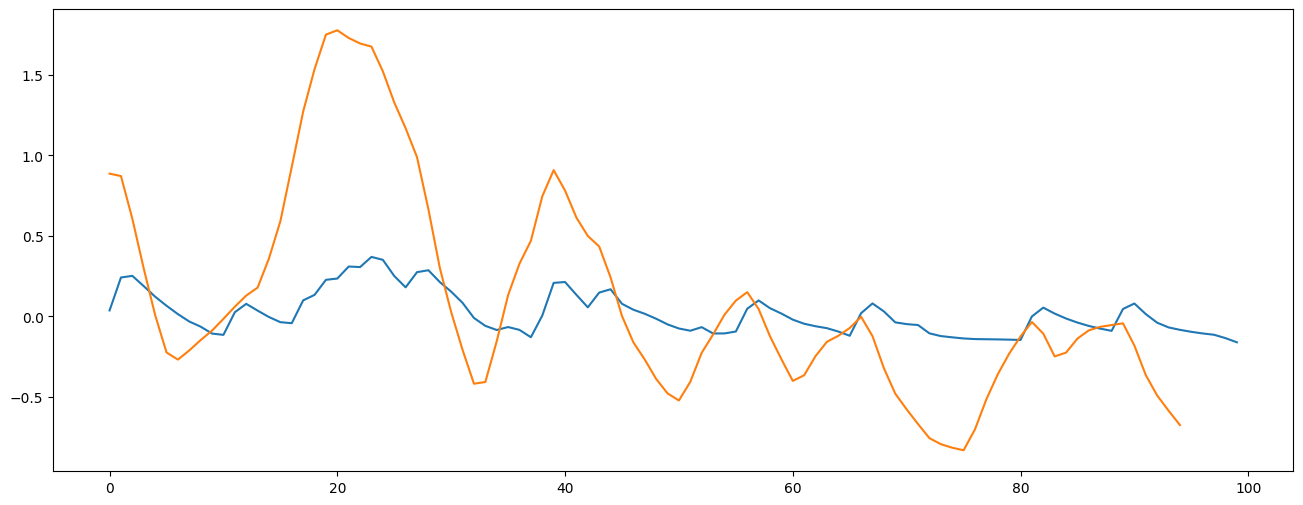

In [227]:
plt.figure(figsize=(16, 6))
plt.plot(rewards[:200])
plt.plot(agents[4]._exp_buffer._total_discounted_rewards[:200])

In [228]:
_ = w_env.reset()

In [229]:
episode = 1

while True:
    # exploration
    for step in range(TRAJECTORY_SIZE):
        actions = {}
        for agent_id, agent in agents.items():
            action = agent.decide_action_and_set()
            actions[agent_id] = action[0]
        agent_ids, states, rewards, dones = w_env.step()
        for agent_id, agent in agents.items():
            agent.update_experience(agent_ids, states, rewards, dones, actions[agent_id])
        if any(dones):
            print(f'episode {episode} done')
            _ = w_env.reset()
            all_agents_rewards = []
            for agent_id, agent in agents.items():
                agent.reset_episode()
                print(f'[ep{episode}] episode_rewards for agent {agent_id} : {agent._episode_rewards[-1]}')
                all_agents_rewards.append(agent._episode_rewards[-1])
            print(f'[ep{episode}] mean episode reward : {sum(all_agents_rewards) / len(all_agents_rewards)}')
            episode += 1
    # train
    for agent_id, agent in agents.items():
        agent.train(ppo_epoch=10, batch_size=64)

UnityCommunicatorStoppedException: Communicator has exited.

In [97]:

while True:
    # exploration
    for step in range(TRAJECTORY_SIZE):
        actions = {}
        for agent_id, agent in agents.items():
            action = agent.decide_action_and_set()
            actions[agent_id] = action[0]
        agent_ids, states, rewards, dones = w_env.step()
        for agent_id, agent in agents.items():
            agent.update_experience(agent_ids, states, rewards, dones, actions[agent_id])
        if any(dones):
            print(f'episode {episode} done')
            _ = w_env.reset()
            all_agents_rewards = []
            for agent_id, agent in agents.items():
                agent.reset_episode()
                print(f'[ep{episode}] episode_rewards for agent {agent_id} : {agent._episode_rewards[-1]}')
                all_agents_rewards.append(agent._episode_rewards[-1])
            print(f'[ep{episode}] mean episode reward : {sum(all_agents_rewards) / len(all_agents_rewards)}')
            episode += 1
    # train
    for agent_id, agent in agents.items():
        agent.train(ppo_epoch=10, batch_size=64)

KeyboardInterrupt: 

In [230]:
env.close()

In [235]:
# state_dicts = {}

# for agent_id, agent in agents.items():
#     state_dicts[f'crt_{agent_id}'] = agent._crt_net.state_dict()
#     state_dicts[f'act_{agent_id}'] = agent._act_net.state_dict()

In [238]:
# torch.save(state_dicts, './tmp_foid_multiagent_1269ep.pth')

In [320]:
# episode = 1

# while True:
#     # exploration
#     for step in range(TRAJECTORY_SIZE):
#         actions = {}
#         for agent_id, agent in agents.items():
#             action = agent.decide_action_and_set()
#             actions[agent_id] = action[0]
#         agent_ids, states, rewards, dones = w_env.step()
#         for agent_id, agent in agents.items():
#             agent.update_experience(agent_ids, states, rewards, dones, actions[agent_id])
#         if any(dones):
#             print(f'episode {episode} done')
#             _ = w_env.reset()
#             all_agents_rewards = []
#             for agent_id, agent in agents.items():
#                 agent.reset_episode()
#                 print(f'[ep{episode}] episode_rewards for agent {agent_id} : {agent._episode_rewards[-1]}')
#                 all_agents_rewards.append(agent._episode_rewards[-1])
#             print(f'[ep{episode}] mean episode reward : {sum(all_agents_rewards) / len(all_agents_rewards)}')
#             episode += 1
#     # train
#     for agent_id, agent in agents.items():
#         agent.train(ppo_epoch=10, batch_size=64)

episode 1 done
[ep1] episode_rewards for agent 0 : -21.921998978592455
[ep1] episode_rewards for agent 1 : -40.05599792022258
[ep1] episode_rewards for agent 2 : -27.72399866487831
[ep1] episode_rewards for agent 3 : -10.13199975900352
[ep1] episode_rewards for agent 4 : -44.28799757733941
[ep1] episode_rewards for agent 5 : -43.07599766366184
[ep1] episode_rewards for agent 6 : -38.303998006507754
[ep1] episode_rewards for agent 7 : -25.31599887367338
[ep1] episode_rewards for agent 8 : -25.55999868363142
[ep1] episode_rewards for agent 9 : -18.32799939252436
[ep1] mean episode reward : -29.4705985520035
episode 2 done
[ep2] episode_rewards for agent 0 : -15.029999407939613
[ep2] episode_rewards for agent 1 : -2.3480003410950303
[ep2] episode_rewards for agent 2 : -36.807998130097985
[ep2] episode_rewards for agent 3 : -33.21999821532518
[ep2] episode_rewards for agent 4 : -36.12399821728468
[ep2] episode_rewards for agent 5 : -45.407997554168105
[ep2] episode_rewards for agent 6 : -2

KeyboardInterrupt: 

In [348]:
# for i in tqdm(range(1000)):
#     for agent in agents:
#         c_acts, d_acts = w_env.random_action()
#         agent.set_action(c_acts, d_acts)
#     agent_ids, states, rewards, dones = w_env.step()
#     if any(dones):
#         print(dones)
#         w_env.reset()
#     # time.sleep(0.1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:39<00:00, 10.05it/s]


In [460]:
env.close()